In [1]:
import logging
from IPython.display import display, Image
import pandas
import plotly

import CS230

plotly.offline.init_notebook_mode(connected=True)

In [2]:
logger = CS230.common.get_logger(level=logging.INFO)

# yaw, pitch, roll

reference: https://en.wikipedia.org/wiki/Aircraft_principal_axes

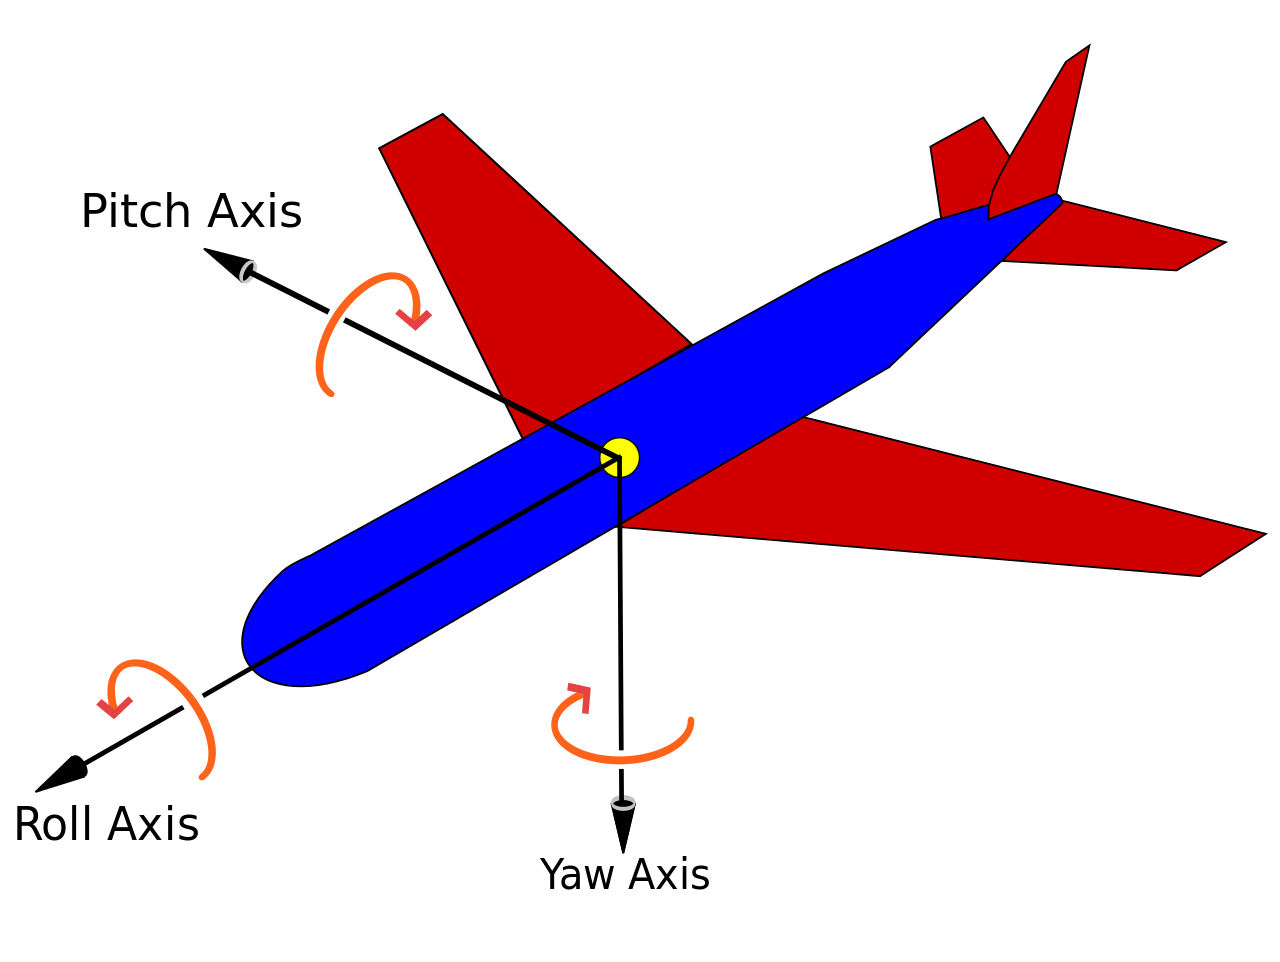

In [3]:
display(Image('images/yaw_pitch_roll.svg.png', width=400, height=500))

# expected input / output correlations

In [4]:
data = {
    'input': ['throttle / brake', 'throttle / brake', 'throttle / brake', 'handwheelAngle', 'handwheelAngle'],
    'output': ['horizSpeed', 'vxCG', 'pitchAngle', 'yawAngle', 'rollAngle']
}
df = pandas.DataFrame(data=data)
df

,input,output
0,throttle / brake,horizSpeed
1,throttle / brake,vxCG
2,throttle / brake,pitchAngle
3,handwheelAngle,yawAngle
4,handwheelAngle,rollAngle


In [21]:
file_paths = CS230.data.get_all_file_paths()
file_path = file_paths[0]
df = CS230.data.load(file_path)
df = CS230.data.stride_rows(df, stride=10)
df = CS230.data.add_derivatives(df, stride=10)
df = CS230.data.clean_discontinuities(df, stride=10)

14-59-51 | INFO | num files: 22


15-04-52 | INFO | wrote: images/2013_Monterey_Motorsports_Reunion/20130810_01_01_01_grandsport-128300-128500-1-1d5f689.jpeg
15-04-52 | INFO | wrote: images/2013_Monterey_Motorsports_Reunion/20130810_01_01_01_grandsport-128300-128500-1-00094c4.jpeg


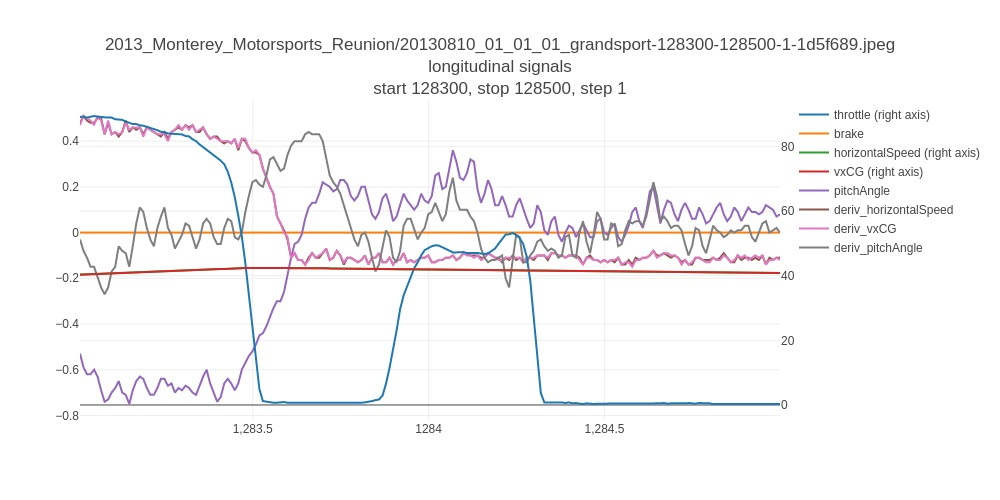

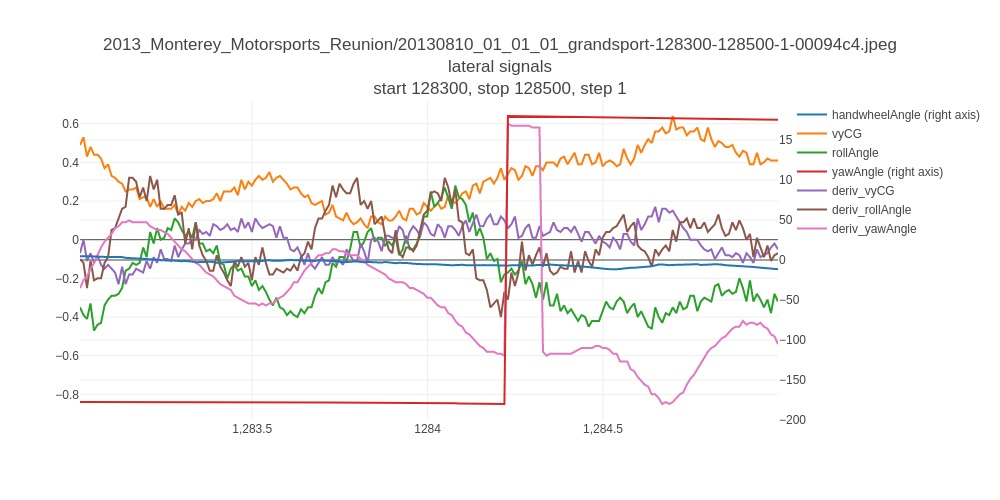

In [23]:
longitudinal_columns = ['throttle', 'brake', 'horizontalSpeed', 'vxCG', 'pitchAngle', 'deriv_horizontalSpeed', 'deriv_vxCG', 'deriv_pitchAngle']
lateral_columns = ['handwheelAngle', 'vyCG', 'rollAngle', 'yawAngle', 'deriv_vyCG', 'deriv_rollAngle', 'deriv_yawAngle']
image_paths = []

fig, image_path = CS230.data.plot(df, file_path, columns=longitudinal_columns, title='longitudinal signals', 
                                  plot=False, write=True, start=128300, stop=128500, step=1)
image_paths.append(image_path)

fig, image_path = CS230.data.plot(df, file_path, columns=lateral_columns, title='lateral signals',
                                  plot=False, write=True, start=128300, stop=128500, step=1)
image_paths.append(image_path)

for i, image_path in enumerate(image_paths):
    display(Image(filename=image_path))

# Objective 1: proof of concept

**hypothesis**: the relationship between input / output pairs above is defined by vehicle specific physics (weight, center of mass, etc.) as well as the environment (road slope, friction, etc.)

**objective**: understand how much of this input / output relationship can be learned from data as opposed to measured and modeled.

# Objective 2: hand engineer features into data set
**hypothesis**: extending input data to have additional features (discrete derivative, max pool, etc.) could impact ability to learn on the data.

**objective**: understand if pre-processing in additional features improve networks ability to learn

# Objective 3: early layers of model create desired features

**hypothesis**: additional features pre-processed into data set from Objective 2 could also be accomplished through additional network layers.

**objective**: explore network designs to achieve at least equal results to pre-processing features.

# Objective 4: connect to PyBullet physics engine

**hypothesis**: [TossingBot: Learning to Throw Arbitrary Objects with Residual Physics](https://ai.googleblog.com/2019/03/unifying-physics-and-deep-learning-with.html) proposes a hybrid approach to unify physics and deep learning by first utilizing physics models then applying deep learning to tune adjustments.
> A fundamental component of TossingBot is that it learns to throw by integrating simple physics and deep learning, which enables it to train quickly and generalize to new scenarios. Physics provides prior models of how the world works, and we can leverage these models to develop initial controllers for our robots. In the case of throwing, for example, we can use projectile ballistics to provide an estimate for the throwing velocity that is needed to get an object to land at a target location. We can then use neural networks to predict adjustments on top of that estimate from physics, in order to compensate for unknown dynamics as well as the noise and variability of the real world.

**objective**: compare accuracy of movement between the following:
1. end-to-end deep learning of vehicle movement
2. vehicle physics model only
3. vehicle physics model + deep learning adjustments